# **Learning trade-off in MGM**
Here we try to show that for any given sequence of observations $$ x_0,x_1,x_2,...,x_t $$ we have a spectrum of explanatory models.

Stochasticity in the observations is explained by different processes in different models for which the likelihood of the observations may be tied.

Specifically we describe an axis in model space defined by two aspects: i) the number of models that may be needed to be combined in order to explain the osbervations ( implied in this are the dynamics of how the different models are combined in time) and ii) the stochasticity of any one of the model componens (whether a model needs to account for all observations).

At the two extremes of this axis, for explaining a stochastic sequence, we have on one extreme i) a bunch of fully deterministic models that  together explain all observations (i.e. stochasticity is absorbed in the switches of model from any time-point to the following time-point) and on the other extreme, we have a single model that has limited predictivity power (i.e. some observations are irreducibly stochastic).

In [1]:
# import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy.random as rnd
#import tensorflow as tf

## Create all dominant patterns within the CTW generative family
Briefly, for any one model we can compute a transition probability matrix, $T_m$ , on the basis of its parameters:

$ T_{\theta^m}  =  \alpha_1*(W_p) + \alpha_2*D^{-1}(E - I - W_p) + \alpha_3*(I)$ 

, where $W_p$ is one of six possible permutation matrices, $E$ is a matrix of ones, and $I$ is the identity matrix, and $ D^{-1} $ is a diagonal matrix that ensures the rows add up to 1, with the constraints that $ \alpha_1 + \alpha_2 + \alpha_3 = 1$ and $ \alpha_1>\alpha_2> \alpha_3>0 $. 

More concretely, if  $ \alpha_1 = 0.66 $ , $ \alpha_2 = 0.33 $ and $ \alpha_3 = 0.01 $, then for the following permutation matrix,

$\begin{equation} 
W^m_p = \begin{bmatrix}  0  &  0  & 1 & 0 \\
0 &  0  &   0  &  1 \\
0  &  1  &  0  &   0 \\
1  &   0  &  0 & 0 \end{bmatrix} 
\end{equation}$

we obtain the following transition probability matrix:

$ T_{\theta^m}   =   \alpha_1\begin{bmatrix}  0  &  0  & 1 & 0 \\
0 &  0  &   0  &  1 \\
0  &  1  &  0  &   0 \\
1  &   0  &  0 & 0 \end{bmatrix} + \alpha_2\begin{bmatrix}  0  &  \tfrac{1}{2}  &  0 & \tfrac{1}{2} \\
\tfrac{1}{2} &  0  &   \tfrac{1}{2}  &  0 \\
\tfrac{1}{2}  &  0  & 0  &   \tfrac{1}{2} \\
0  &   \tfrac{1}{2}  &  \tfrac{1}{2} &  0 \end{bmatrix} + \alpha_3\begin{bmatrix}  1  & 0  &  0 & 0 \\
0 &  1  &  0  &  0 \\
0  &  0  &  1  &   0 \\
0  &   0  &  0 &  1 \end{bmatrix}  = \begin{bmatrix} 0.01  & 0.16  &  0.66  &  0.16 \\
0.16  &  0.01  &  0.16  &  0.66 \\
0.16  &  0.66  &  0.01  &  0.16 \\
0.66  &  0.16  &  0.16  &  0.01 \end{bmatrix}  $ 

Below we create all the permutation matrices within the CTW generative family

 

In [2]:
# start with a vector of zeros (of with 6*4*4 elements)
Wps = np.zeros([6*4*4])
# manually define all the cells that contain a dominant transition
wh_dom = np.array([3,6,8,13,17,23,24,30,34,36,43,45,50,55,57,60,65,70,75,76,83,84,89,94])
Wps[wh_dom] = 1
# reshape into a model*valuein*valueout array
Wps = np.reshape(Wps,[6,4,4])

Here, we define the true generative model, as a matrix of transition probabilities from one state to another. We make use of the (already defined) true dominant pattern and we define and use the true dominant transition probability value:

$ \alpha = 0.75 $

In [3]:
# select the fourth pattern model as the dominant pattern model
Wp = Wps[3,:,:]
#print(Wp)
 
alpha = 0.75
E = np.ones([4,4])
I = np.identity(4)
D = E-I-(Wp)
D = D/np.sum(D,0)
#print(D)
tGM = Wp*alpha + D*(1-alpha)
#print(tGM)

# we can already create the D matrix for all dominant patterns
aE = np.reshape(E,[1,4,4])
aI = np.reshape(I,[1,4,4])
aD = aE-aI-Wps
aD = aD/np.reshape(np.sum(aD,1),[6,1,4])

## Make a bunch of simulated sequences of observations
Now, we create a few random sequences of 50 transitions as sampled from the true generative model

In [4]:
num_t = 50
num_seqs = 100

seq = np.zeros([4,num_t,num_seqs])
seq_d = np.zeros([num_t,num_seqs])
for js in range(0,num_seqs):
  in_st = rnd.randint(4)
  j_seq = []
  j_seq_d = []
  for it in range(0,num_t):
    p_vec  = tGM[in_st,:]
    p_cum  = np.cumsum(p_vec)
    rnd_dr = rnd.random_sample()
    is_high = rnd_dr > np.hstack((0, p_cum[0:-1]))
    is_low  = rnd_dr < np.hstack((p_cum[:-1],1))
    out_st   = is_high&is_low
    out_st_d =  np.argwhere(out_st)
    j_seq = np.append(j_seq,out_st)
    j_seq_d = np.append(j_seq_d,out_st_d)
    in_st = out_st_d
  j_seq_fl = np.swapaxes(np.reshape(j_seq,[num_t,4]),axis1=1,axis2=0)
  seq_d[:,js] = j_seq_d
  seq[:,:,js] = j_seq_fl
#print(seq)

# convert the sequence from digit format to one-hot encoding
#a = np.int_(seq)
#seq_1h = np.zeros((a.size, a.max()+1))
#seq_1h[np.arange(a.size),a] = 1

Now we want to obtain the likelihood of each transition under each of the possible models within the generative family.
We define a transition as the combination of a pair of consecutive observations indexed by trial $ tr_t = \{ s_{t-1},s_{t} \}$.
We want to obtain the likelihood of an observed transition given a model as parameterised by a permutation matrix and a dominant transition probability value, $\alpha$:

$P(tr_t|Wp_x,\alpha)$


In [5]:
# define transitions as pairs of consecutive observations
x_in  = seq[:,:-1,:] # from first to second-to-last
x_out = seq[:,1:,:]  # from second to last

# take care of dimensions to allow for element-wise multiplication
x_in_6d = np.reshape(x_in,[1,4,1,(num_t-1),num_seqs,1])
x_out_6d = np.reshape(x_out,[1,1,4,(num_t-1),num_seqs,1])

#W = x_in_5d*x_out_5d
n_alph = 101
alphas = np.linspace((1/3),1,n_alph)
alphas_6d = np.reshape(alphas,[1,1,1,1,1,n_alph])

Wps_6d = np.reshape(Wps,[6,4,4,1,1,1])
aD_6d  = np.reshape(aD,[6,4,4,1,1,1])
#print(x_in_5d.shape)
#print(Wps_5d.shape)
#print(alphas_5d.shape)

like_dom_tr = Wps_6d*x_in_6d*x_out_6d*alphas_6d
like_ndom_tr = aD_6d*x_in_6d*x_out_6d*(1-alphas_6d)
like_tr = like_dom_tr+like_ndom_tr


<ipython-input-6-11b0005ca81b>:5: RuntimeWarning: divide by zero encountered in log
  log_like_tr = np.log(like_tr_m)


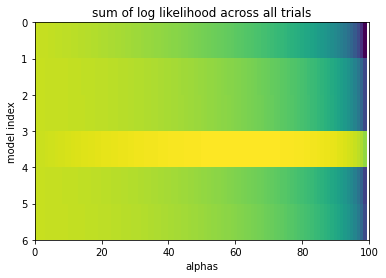

In [6]:
# compute the likelihood of each transition independently for each model
like_tr_m = np.sum(like_tr,axis=1)
like_tr_m = np.sum(like_tr_m,axis=1)

log_like_tr = np.log(like_tr_m)

# get the average over the different simulated sequences
avg_loglike_tr_m = np.mean(log_like_tr,axis=2)

sum_ll_2d  = np.nansum(avg_loglike_tr_m,axis=1)
#sum_ll_2d.shape
#print(sum_ll_2d)

plt.imshow(sum_ll_2d, extent=[0,100,6,0], aspect='auto',cmap='viridis')
plt.title('sum of log likelihood across all trials')
plt.xlabel('alphas')
plt.ylabel('model index')
plt.show()

Start looking at the likelihood under the assumption of there being a single model throughout the sequence (i.e. zero volatility) for any model within the generative family

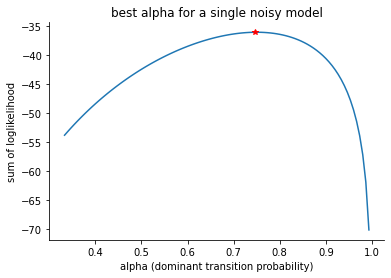

In [7]:
# look at the likelihood curve for the best pattern (i.e., from model 4)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

log_like_for_pat4 = sum_ll_2d[3,]
plt.plot(alphas,log_like_for_pat4)

# mark max
wh_max_llike = np.argwhere(np.max(log_like_for_pat4) == log_like_for_pat4)
plt.plot(alphas[wh_max_llike],np.max(log_like_for_pat4),'r*')

plt.title('best alpha for a single noisy model')
plt.xlabel('alpha (dominant transition probability)')
plt.ylabel('sum of loglikelihood')
plt.show()

Now let's go to the other extreme: a mixture of deterministic models
and compute the likelihood of the transitions under this model

Note: this is still the OLD parameterisation of gamma.
We eventually want to make $$ \gamma = C/(N+C) $$

(6, 6, 99)


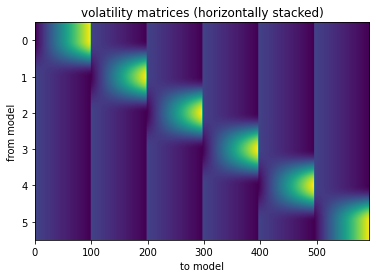

In [8]:
# define the levels of volatility
n_gamm = 99
gammas = np.linspace(0,1,n_gamm)
gammas_3d = np.reshape(gammas,[1,1,n_gamm])
#gammas_6d = np.reshape(gammas,[1,1,1,1,1,n_gamm])
#print(gammas.shape)

# here the volaitility is seen as a diagonal matrix
vol_I = np.reshape(np.identity(6),[6,6,1])

# we can also see the volaitlity as a rank1 matrix, where model 4 is the most likely model
#vol_I = np.reshape(np.zeros([6,6]),[6,6,1])
#vol_I[:,3] = 1


# a matrix of ones (used for substracting the gamma part)
vol_E = np.reshape(np.ones([6,6]),[6,6,1])

vol_mat = gammas_3d*vol_I + ((1-gammas_3d)/5)*(vol_E-vol_I)
#print(vol_mat)
print(vol_mat.shape)

vol_mat_slice = vol_mat[:,:,70]
vol_mat_2d = np.reshape(vol_mat,[6,6*99])

plt.imshow(vol_mat_2d,aspect='auto',cmap='viridis')
plt.title('volatility matrices (horizontally stacked)')
plt.xlabel('to model')
plt.ylabel('from model')
plt.show()


In [9]:
# retrieve the likelihood under all deterministic models
like_tr_m_det = like_tr_m[:,:,:,-1]
#print(like_tr_m_det.shape)

# now get the diffused likelihood 
# (i.e. the likelihood after being passed through the volatility matrix)
like_tr_t0 = np.reshape(like_tr_m_det[:,:-1,:],[6,1,num_t-2,num_seqs,1,1])
like_tr_t1 = np.reshape(like_tr_m_det[:,1:,:],[1,6,num_t-2,num_seqs,1,1])

# print(like_tr_m_det.shape)
# print(like_tr_t0.shape)
# print(like_tr_t1.shape)
vol_mat_6d = np.reshape(vol_mat,[6,6,1,1,1,n_gamm])
joint_tr_tr = like_tr_t0*like_tr_t1
like_tr_m_swi = vol_mat_6d*joint_tr_tr

max_like_switch = np.max(like_tr_m_swi,0)
#print(max_like_switch.shape)
max_like_switch = np.max(max_like_switch,0)
#print(max_like_switch.shape)
log_maxlike = np.log(max_like_switch)
sum_log_maxlike = np.nansum(log_maxlike,0)
#print(sum_log_maxlike)

<ipython-input-9-cc336c2719b7>:21: RuntimeWarning: divide by zero encountered in log
  log_maxlike = np.log(max_like_switch)


## Obtain the posterior over models at each timestep
for this we have a likelihood of a transition at each timestep (given each model) which gets diffused in time via the volatility matrix

In [13]:
# define variables and shapes
prior_m = np.ones([6,1,num_t,num_seqs,1,n_gamm])/6
post_m = np.zeros(np.shape(prior_m))
like_tr_m_det_rshp = np.reshape(like_tr_m_det,[6,1,num_t-1,num_seqs,1,1])

# we do this in a loop
for it in range(num_t-1):

    # combine prior and likelihood
    i_post = prior_m[:,:,it,:,:]*like_tr_m_det_rshp[:,:,it,:,:]
    norm_post = i_post/np.nansum(i_post,axis=0)
    post_m[:,:,it,:] = norm_post

    # diffuse the posterior (though volatility matrix) to get prior for next trial  
    diff_post = post_m[:,:,it,:,:]*vol_mat_6d
    prior_m[:,:,it+1,:,:] = np.sum(diff_post,axis=1)

#jont_tr_tr = like_tr_t0*like_tr_t1;
#like_tr_m_swi = vol_mat_4d*joint_tr_tr;

<ipython-input-13-bc0a306dfa2d>:11: RuntimeWarning: invalid value encountered in true_divide
  norm_post = i_post/np.nansum(i_post,axis=0)


In [17]:
ig = 20
it = 34
W1 = np.reshape(prior_m[:,:,it+1,:,:],[6,num_seqs,99])
W2 = np.reshape(prior_m[:,:,:,:,ig],[6,num_t,num_seqs])
W3 = np.reshape(post_m[:,:,it,:,:],[6,num_seqs,99])
W4 = np.reshape(post_m[:,:,:,:,ig],[6,num_t,num_seqs])
'''
fig = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(W1, aspect='auto',cmap='viridis')
plt.title('prior for trial t')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.subplot(2, 2, 2)
plt.imshow(W2, aspect='auto',cmap='viridis')
plt.title('prior for all trials at a set gamma')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.subplot(2, 2, 3)
plt.imshow(W3, aspect='auto',cmap='viridis')
plt.title('posterior for trial t-1')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.subplot(2, 2, 4)
plt.imshow(W4, aspect='auto',cmap='viridis')
plt.title('posterior for all trials')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')

plt.show()
'''

IndexError: index 20 is out of bounds for axis 4 with size 1

In [25]:

it = 24
vol_mat_4d = np.reshape(vol_mat_6d,[6,6,1,n_gamm])
# get trial t posterior
i_post_t0 = np.reshape(post_m[:,:,it,:,:,:],[6,1,num_seqs,n_gamm])

# get the likelihood of the transition at time t+1 and t+2
i_like_t1 = np.reshape(like_tr_m_det_rshp[:,:,it+1,:,:],[1,6,num_seqs,1])
i_like_t2 = np.reshape(like_tr_m_det_rshp[:,:,it+2,:,:],[1,6,num_seqs,1])

# compute the likelihood of paths from post_t0 to like_t1 and from like_t1 to like_t2 
i_path1_like = i_post_t0*vol_mat_4d*i_like_t1
i_path2_like = np.reshape(i_like_t1,[6,1,num_seqs,1])*vol_mat_4d*i_like_t2

# maximum likelihood path t1 (from posterior at time t0 to likelihood at time t+1)
max_like_path1 = np.max(np.sum(i_path1_like,axis=0),axis=(1))
max_like_path2 = np.max(np.sum(i_path2_like,axis=0),axis=(1))# np.max(i_path2_like,axis=(1))


#print(max_like1[:,:,75])
print(np.squeeze(i_post_t0[:,:,0,75]))
print(np.squeeze(i_like_t1[:,:,0]))
print(np.squeeze(i_path1_like[:,:,0,75]))
#print(max_like_path1)
#print(np.squeeze(np.sum(like_path1b[:,:,:,75],axis=1)))


[0.         0.         0.06361824 0.93638176 0.         0.        ]
[0. 0. 0. 1. 0. 1.]
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.00298616 0.         0.00298616]
 [0.         0.         0.         0.71661869 0.         0.04395261]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [32]:
vol_mat_4d = np.reshape(vol_mat_6d,[6,6,1,n_gamm])
llike_mix_det_mod = np.ones([num_t,num_seqs,n_gamm])/6

for it in range(num_t-3):
    # get trial t posterior
    i_post_t0 = np.reshape(post_m[:,:,it,:],[6,1,num_seqs,n_gamm])

    # get the likelihood of the transition at time t+1 and t+2
    i_like_t1 = np.reshape(like_tr_m_det_rshp[:,:,it+1,:],[1,6,num_seqs,1])

    # compute the likelihood of paths from post_t0 to like_t1 and from like_t1
    i_path1_like = i_post_t0*vol_mat_4d*i_like_t1

    # maximum likelihood path t1 (from posterior at time t0 to likelihood at time t+1)
    max_like_path1 = np.max(np.sum(i_path1_like,axis=0,keepdims=1),axis=1)

    llike_mix_det_mod[it+1,:,:] = np.log(max_like_path1)
#jont_tr_tr = like_tr_t0*like_tr_t1;

<ipython-input-32-f0081e23dea7>:17: RuntimeWarning: divide by zero encountered in log
  llike_mix_det_mod[it+1,:,:] = np.log(max_like_path1)


In [18]:
'''
#plt.imshow(log_maxlike,extent=[0,n_gamm,num_t-2,0], aspect='auto',cmap='viridis')
plt.imshow(like_mix_det_mod, aspect='auto',cmap='viridis')
plt.title('likelihood of volatility parameter for each transition pair')
plt.xlabel('gamma (inverse volatility)')
plt.ylabel('transition')
plt.show()
'''

"\n#plt.imshow(log_maxlike,extent=[0,n_gamm,num_t-2,0], aspect='auto',cmap='viridis')\nplt.imshow(like_mix_det_mod, aspect='auto',cmap='viridis')\nplt.title('likelihood of volatility parameter for each transition pair')\nplt.xlabel('gamma (inverse volatility)')\nplt.ylabel('transition')\nplt.show()\n"

(6, 49, 100, 101)
(50, 100, 99)
(49, 100, 101)


[Text(0, 0.5, 'cumulative likelihood')]

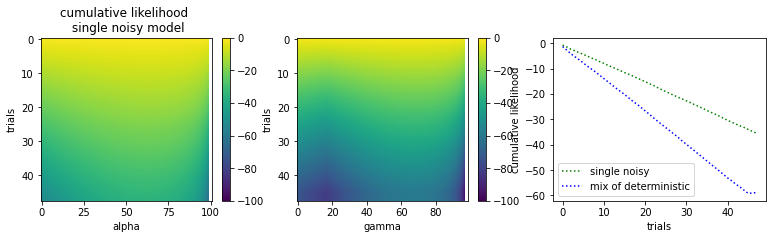

In [71]:
# get ready for plotting the results

# this is the likelihood of each transition (independently) under each posible single model
print(log_like_tr.shape)

# here's the likelihood of each transition (independently) under a mix of deterministic models for different volatility levels
print(llike_mix_det_mod.shape)

# we know that the true model is model 4 (index 3)
like_tr_best_mod = np.squeeze(log_like_tr[3,:,:,:])
print(like_tr_best_mod.shape)

# get the cumulative likelihood as trials tally up
cum_like_singlenoisy = np.cumsum(like_tr_best_mod[1:,:,:],axis=0)
cum_like_mixdetmods = np.cumsum(llike_mix_det_mod[2:,:,:],axis=0)

# now thake the expectation over the different simulated sequences
avg_cum_like_singlenoisy = np.mean(cum_like_singlenoisy,axis=1)
avg_cum_like_mixdetmods = np.mean(cum_like_mixdetmods,axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)
singlenoisy = ax1.imshow(avg_cum_like_singlenoisy,aspect='auto',cmap='viridis', vmin=-100, vmax=0)
fig.colorbar(singlenoisy, ax=ax1,  location='right')

mixofdet = ax2.imshow(avg_cum_like_mixdetmods,aspect='auto',cmap='viridis', vmin=-100, vmax=0)
fig.colorbar(mixofdet, ax=ax2, location='right')

max_single = np.nanmax(avg_cum_like_singlenoisy,axis=1)
max_mix = np.nanmax(avg_cum_like_mixdetmods,axis=1)

L1 = ax3.plot(max_single,'g:')
L2 = ax3.plot(max_mix,'b:')
ax3.legend(['single noisy','mix of deterministic'])


# set labels
plt.setp(ax1, xlabel='alpha')
plt.setp(ax1, ylabel='trials')
plt.setp(ax1, title='cumulative likelihood \n (single noisy model)')

plt.setp(ax2, xlabel='gamma')
plt.setp(ax2, ylabel='trials')
plt.setp(ax2, title='cumulative likelihood \n (mix of deterministic models)')

plt.setp(ax3, xlabel='trials')
plt.setp(ax3, ylabel='cumulative likelihood')
plt.setp(ax3, title='cumulative likelihood \n (max over aprameters for each trial)')


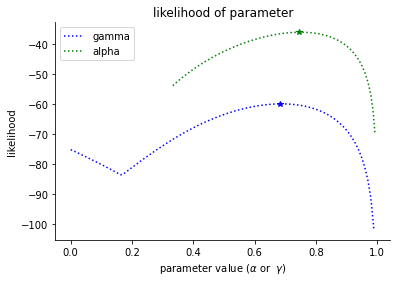

In [33]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

sum_log_like_mix_det_mod = np.mean(np.nansum(llike_mix_det_mod,axis=0),axis=0)


line1 = plt.plot(gammas,sum_log_like_mix_det_mod,'b:')

log_like_for_pat4 = sum_ll_2d[3,]
line2 = plt.plot(alphas,log_like_for_pat4,'g:')


# mark max gamma
wh_max_llike = np.argwhere(np.max(sum_log_like_mix_det_mod) == sum_log_like_mix_det_mod)
plt.plot(gammas[wh_max_llike],np.max(sum_log_like_mix_det_mod),'b*')

# mark max alpha
wh_max_llike = np.argwhere(np.max(log_like_for_pat4) == log_like_for_pat4)
plt.plot(alphas[wh_max_llike],np.max(log_like_for_pat4),'g*')


plt.title('likelihood of parameter')
plt.ylabel('likelihood')
plt.xlabel('parameter value (' r'$\alpha$ or  $\gamma$)')
ax.legend(['gamma','alpha'])
plt.show()